# Muller-Kubie experiments

This notebook reproduces the place field remapping experiments in a circular arena,  
with results corresponding to Figure 3B of our [paper](https://www.science.org/doi/epdf/10.1126/sciadv.adm8470).


## Imports

In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})




from cscg import cscg_factory
from cscg import utils

## Create environments and generate training data

In [2]:
# @title Training layout
PH, PW = 9, 3
radius, wall_thickness, cue_rows = 7.5, 3, 4
arena_size = 33
room_layout = utils.generate_circular_layout(
    arena_size, radius, wall_thickness, cue_rows
)

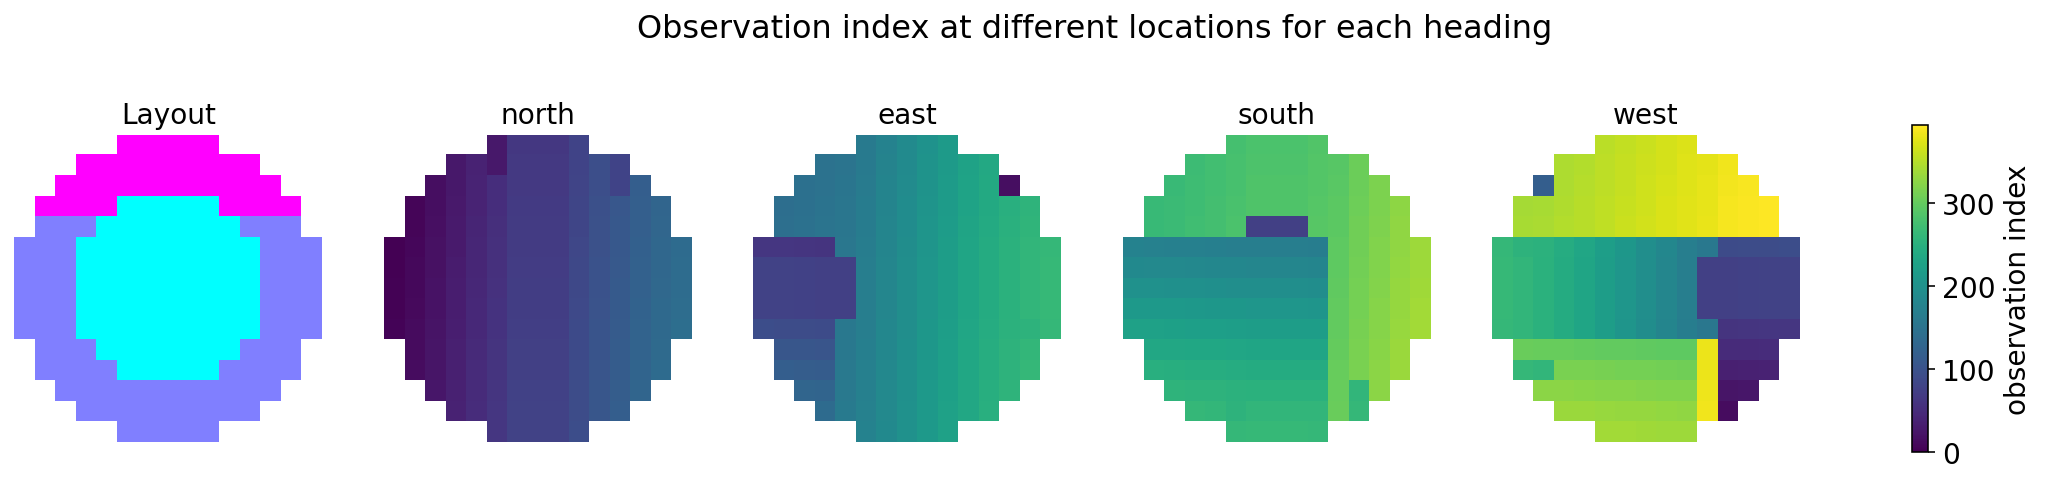

In [3]:
# generate egocentric observations

observation_dict = {}
observation_map, observation_dict = utils.extract_egocentric_observations(
    room_layout, PH, PW, observation_dict
)

labels = ['Layout', 'north', 'east', 'south', 'west']
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
po = PH
axs[0].imshow(utils.nan_outside(room_layout[po:-po, po:-po]), cmap='cool')
for i in range(5):
  if i > 0:
    pcm = axs[i].imshow(
        utils.nan_outside(observation_map[i - 1][po:-po, po:-po]),
        vmin=0,
        vmax=observation_map.max(),
    )
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].set_title(labels[i], fontsize=14)
  axs[i].axis('off')

fig.colorbar(pcm, ax=axs, shrink=0.75, label='observation index')
plt.suptitle('Observation index at different locations for each heading', fontsize=16)
plt.show()

In [4]:
# @title Generate training data for the CSCG in the original layout

length = 250_000
H, W = observation_map.shape[1:]
sr, sc, sh = H // 2, W // 2, 0

a, x, rc, h = utils.generate_egocentric_random_walk(
    observation_map.copy(), sr, sc, sh, length, seed=42
)

print(x.shape, a.shape)

(250000,) (250000,)


## Train CSCG

In [5]:
# @title set n_clones
n_emissions = observation_map.max() + 1
n_clones = np.unique(observation_map, return_counts=True)[1][1:]  # ignore obs index -1, which corresponds to patches outside the room
n_clones = 4 * (np.unique(observation_map, return_counts=True)[1][1:])

In [7]:
# @title Initialize CSCG
pseudocount = 5e-4
kwargs = dict(
    n_clones=n_clones,
    pseudocount=pseudocount,
    n_actions=len(np.unique(a)),
    batched=True,
    use_bfloat16=False,
)

model = cscg_factory.build_cscg(implementation='he', seed=0, kwargs=kwargs)

In [8]:
# @title EM learning
convergence_em = model.learn_em_transition(
    observations=x, actions=a, n_iter=1000
)

 58%|█████▊    | 582/1000 [05:32<03:58,  1.75it/s, train_bps=0.021828437]


In [9]:
# @title Viterbi learning
convergence_vit = model.learn_viterbi_transition(
    observations=x, actions=a, n_iter=100
)

  3%|▎         | 3/100 [00:02<01:32,  1.04it/s, train_bps=0.0062565636]


In [10]:
# @title Decode states
states = model.decode(observations=x, actions=a)[1]
print(
    'No. of locations in the room x No. of headings =',
    (room_layout > -1).sum() * 4,
)
print(f'No. of unique states decoded: {len(np.unique(states))}')

No. of locations in the room x No. of headings = 708
No. of unique states decoded: 691


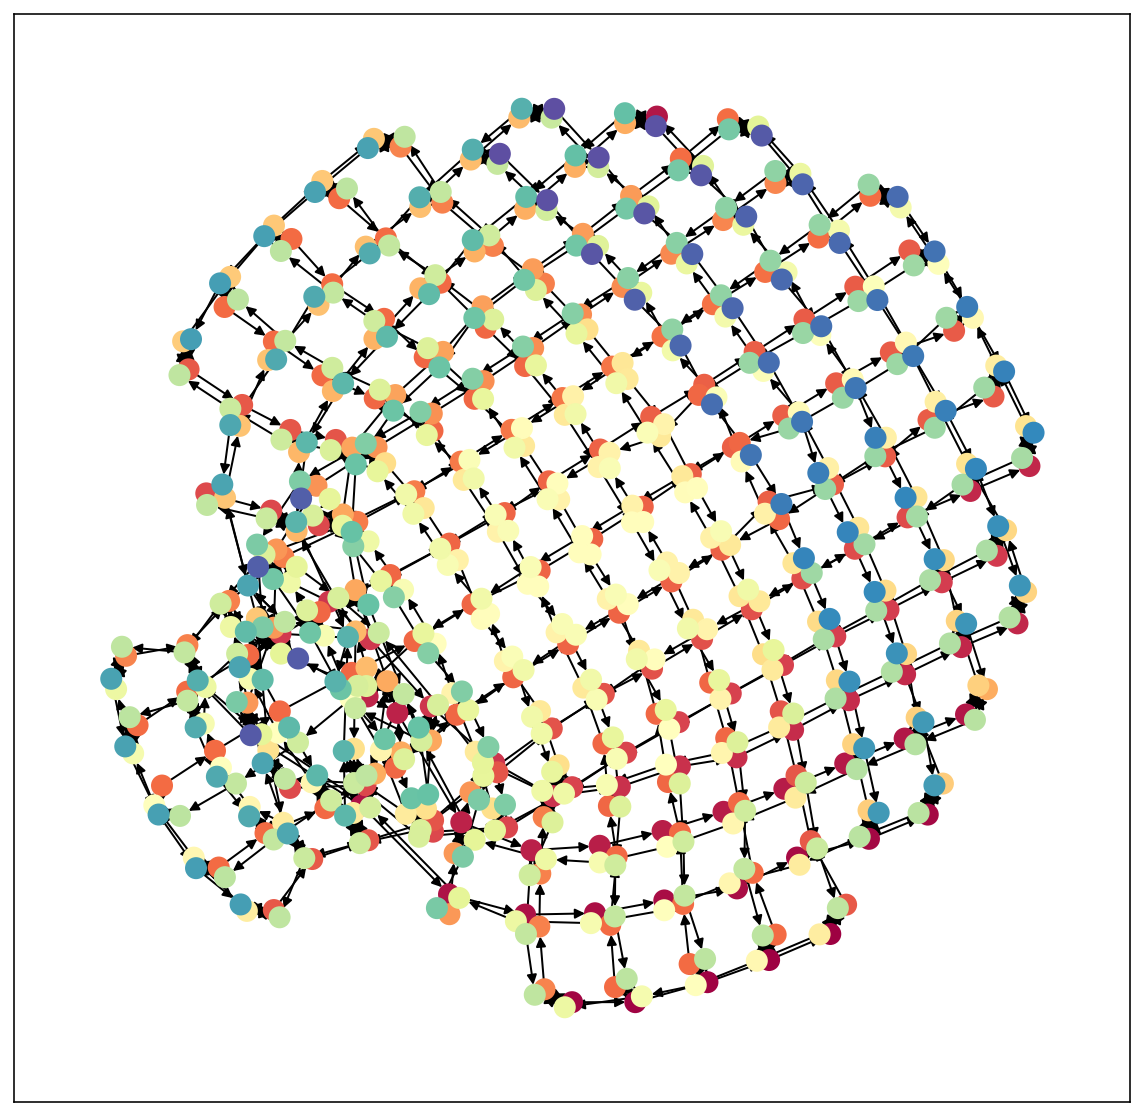

In [11]:
# @title Learnt graph
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.plot_graph(
    model.counts_matrix, states, n_clones, x.max(), ax=ax, node_size=100
)

In [12]:
# @title Create SE version of model
model_se = cscg_factory.build_cscg(implementation='se', seed=0, kwargs=kwargs)
model_se.set_pseudocount(0.0)
model_se.set_counts_matrix(model.counts_matrix)

In [13]:
# @title Map clones to positions in the layout
clones = np.unique(states)
node_pos_a = {}
for i, state in enumerate(np.array(states)):
  ri, ci = rc[i]
  ri -= PH
  ci -= PH
  hi = h[i]

  if (ri, ci, hi) not in node_pos_a:
    node_pos_a[(ri, ci, hi)] = {}

  if (ri, ci, hi) in node_pos_a:
    if state not in node_pos_a[(ri, ci, hi)]:
      node_pos_a[(ri, ci, hi)][state] = 0
    node_pos_a[(ri, ci, hi)][state] += 1

# now for each node position, find state with max values
node_pos = {}
for ri, ci, hi in node_pos_a:
  keys = list(node_pos_a[(ri, ci, hi)].keys())
  vals = list(node_pos_a[(ri, ci, hi)].values())
  clone = keys[np.argmax(vals)]
  clone_idx = np.where(clones == clone)[0][0]
  node_pos[(ri, ci, hi)] = (clone, clone_idx)

In [14]:
E_true = jnp.array(model_se.emission_matrix_default.copy())

# Compute Hamming distance between templates
templates = list(observation_dict.keys())
templates = np.array(templates)

# Hamming distance matrix
Nh = len(templates)
HMat = np.zeros(shape=(Nh, Nh))
for i in range(Nh):
  for j in range(i):
    HMat[i, j] = np.sum(templates[i] != templates[j])
    HMat[j, i] = HMat[i, j]

# Soft observation matrix
X_scaling = 0.1
x_soft = np.exp(-(HMat**2) / (2 * X_scaling))

In [15]:
# @title Compute place fields in original layout
trial_len, num_trials = 500, 100
gaussian_half_window_size = 7
gaussian_scaling = 32


RFs = utils.compute_receptive_fields(
    clones,
    model_se,
    E_true,
    observation_map.copy(),
    trial_len=trial_len,
    num_trials=num_trials,
    gaussian_half_window_size=gaussian_half_window_size,
    gaussian_scaling=gaussian_scaling,
    x_soft=x_soft,
    seed=42,
)

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


## Effect of rotating cue on the angular position of place fields

In [16]:
# @title Rotated circular layout

observation_map_rotated = observation_map.copy()
observation_map_rotated[0] = np.rot90(observation_map[3], k=-1, axes=(0, 1))
observation_map_rotated[1] = np.rot90(observation_map[0], k=-1, axes=(0, 1))
observation_map_rotated[2] = np.rot90(observation_map[1], k=-1, axes=(0, 1))
observation_map_rotated[3] = np.rot90(observation_map[2], k=-1, axes=(0, 1))

room_layout_rotated = np.rot90(room_layout, k=-1, axes=(0, 1))

In [17]:
# @title Compute place fields in rotated layout

RFs_rotated = utils.compute_receptive_fields(
    clones,
    model_se,
    E_true,
    observation_map_rotated.copy(),
    trial_len=trial_len,
    num_trials=num_trials,
    gaussian_half_window_size=gaussian_half_window_size,
    gaussian_scaling=gaussian_scaling,
    x_soft=x_soft,
    seed=42,
)

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


## Effect of introducing opaque barrier on place fields

In [18]:
room_layout_barrier = room_layout.copy()

for i in range(H // 2 + 1):
  room_layout_barrier[i, H - i - 1] = -1

observation_map_barrier, observation_dict_barrier = (
    utils.extract_egocentric_observations(
        room_layout_barrier, PH, PW, observation_dict.copy()
    )
)

In [19]:
# compute Hamming distance matrix for templates in modified room vs original room
templates = list(observation_dict.keys())
templates = np.array(templates)

templates_b = list(observation_dict_barrier.keys())
templates_b = np.array(templates_b)

# Hamming distance matrix
Nh = len(templates)
Nh_b = len(templates_b)

HMat_b = np.zeros(shape=(Nh_b, Nh))
for i in range(Nh_b):
  for j in range(Nh):
    HMat_b[i, j] = np.sum(templates_b[i] != templates[j])

# soft observation matrix
X_scaling = 0.1
x_soft_b = np.exp(-(HMat_b**2) / (2 * X_scaling))

In [20]:
# @title Compute place fields in layout with barrier

RFs_barrier = utils.compute_receptive_fields(
    clones,
    model_se,
    E_true,
    observation_map_barrier.copy(),
    trial_len=trial_len,
    num_trials=num_trials,
    gaussian_half_window_size=gaussian_half_window_size,
    gaussian_scaling=gaussian_scaling,
    x_soft=x_soft_b,
    seed=42,
)

100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


## Plotting place fields

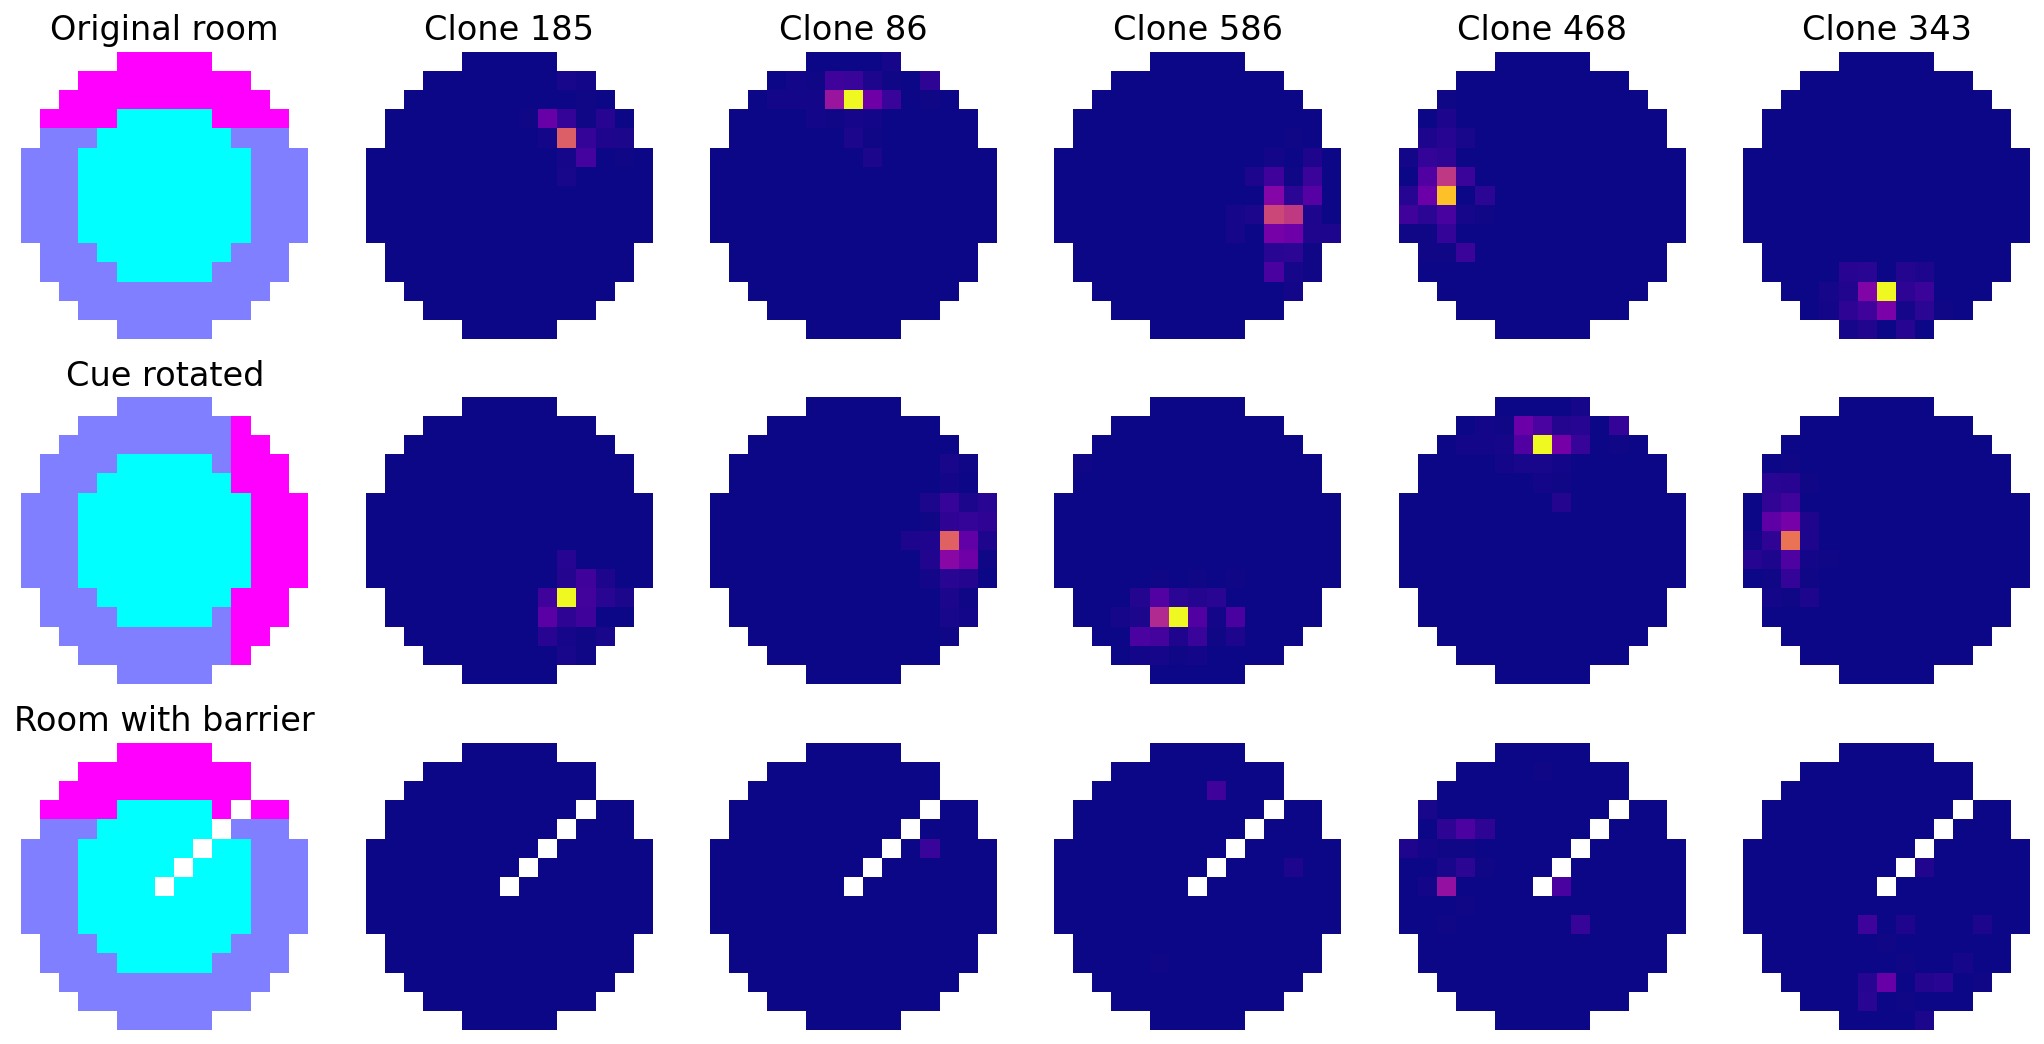

In [21]:
# selected_cells = np.random.randint(0, len(clones), 5)

locations = [(4, 10, 0), (2, 7, 0), (8, 11, 2), (7, 2, 3), (12, 7, 1)]
selected_cells = [node_pos[(ri, ci, hi)][1] for ri, ci, hi in locations]


cmap = 'plasma'

fig, axs = plt.subplots(
    nrows=3,
    ncols=len(selected_cells) + 1,
    figsize=(3 * len(selected_cells) + 3, 9),
)

axs[0, 0].imshow(utils.nan_outside(room_layout[po:-po, po:-po]), cmap='cool')
axs[0, 0].axis('off')
axs[0, 0].set_title('Original room')

axs[1, 0].imshow(
    utils.nan_outside(room_layout_rotated[po:-po, po:-po]), cmap='cool'
)
axs[1, 0].axis('off')
axs[1, 0].set_title('Cue rotated')


axs[2, 0].imshow(
    utils.nan_outside(room_layout_barrier[po:-po, po:-po]), cmap='cool'
)
axs[2, 0].axis('off')
axs[2, 0].set_title('Room with barrier')

for i, cell in enumerate(selected_cells):
  rmax = max([
      utils.findmax(RFs[cell]),
      utils.findmax(RFs_rotated[cell]),
      utils.findmax(RFs_barrier[cell]),
  ])
  axs[0, i + 1].imshow(RFs[cell][po:-po, po:-po], cmap=cmap, vmin=0, vmax=rmax)
  axs[0, i + 1].axis('off')

  axs[1, i + 1].imshow(
      RFs_rotated[cell][po:-po, po:-po], cmap=cmap, vmin=0, vmax=rmax
  )
  axs[1, i + 1].axis('off')

  axs[2, i + 1].imshow(
      RFs_barrier[cell][po:-po, po:-po], cmap=cmap, vmin=0, vmax=rmax
  )
  axs[2, i + 1].axis('off')

  axs[0, i + 1].set_title(f'Clone {cell}')

plt.show()